# Self Attention

Self-attention is a mechanism used in neural networks for processing sequential data, such as natural language text. It allows the network to weigh the importance of different input tokens while processing each token, based on their relationships with other tokens in the sequence. This can improve the network's ability to capture long-range dependencies and improve performance on tasks such as language modeling, machine translation, and summarization

#### The self attention logic consists of 3 main components

Query vector : What I am looking for ? [$sequence_{length}$ x $d_k$]

Key vector : What I can offer ? [$sequence_{length}$ x $d_k$]

Value vector : What I actually offer ? [$sequence_{length}$ x $d_v$]

In [1]:
import numpy as np
import math

In [2]:
L = 4            #sequence length
d_k = 8          #Key vector depth
d_v = 8          #Value vector depth

Now we will randomly initialize these vectors , but remember these are going to be your input vectors, this means they wont be random and each of them will have certain meaning of itself.

In [3]:
q = np.random.rand(L, d_k)
k = np.random.rand(L, d_k)
v = np.random.rand(L, d_v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)

Q
 [[7.52693105e-01 8.41580563e-03 3.31019286e-04 8.97157650e-01
  4.56170924e-02 5.70429534e-01 3.67254418e-01 5.02569250e-01]
 [7.23369714e-01 6.19765185e-01 3.98904336e-01 8.61107423e-01
  1.46284758e-01 3.90607989e-01 9.91994667e-01 5.65312292e-01]
 [6.39388865e-01 1.30754719e-01 6.21434922e-01 9.79058090e-01
  7.48285994e-01 1.11900671e-01 9.96873555e-01 2.78966113e-01]
 [5.60582814e-01 5.22478141e-01 3.50465399e-01 6.33301196e-01
  9.58188269e-01 3.44813768e-01 9.95591738e-01 6.79213608e-01]]
K
 [[0.36940241 0.04758322 0.83227899 0.58179784 0.76644583 0.41606289
  0.78130063 0.83697154]
 [0.31768957 0.63863752 0.71029805 0.74194598 0.12293787 0.39578146
  0.60758719 0.66235779]
 [0.37980848 0.40041257 0.58743129 0.976559   0.02782404 0.55686997
  0.43654198 0.30334982]
 [0.76736693 0.45626942 0.1207564  0.72951051 0.59864137 0.73650732
  0.36305381 0.58976947]]
V
 [[0.16361751 0.73154278 0.21663838 0.03725605 0.60247861 0.3641873
  0.7826611  0.78808985]
 [0.8367454  0.54962405 0

##### The Self Attention Equation is given

$$Self-Attention = softmax(\frac{Q.K^T}{\sqrt(d_k)}+M)V$$


The `Q.K^T` operation can be thought of as a similarity measure between the query and key vectors. The dot product of two vectors measures the **cosine similarity** between them, which ranges from -1 (opposite directions) to 1 (same direction). 

The $\sqrt d_k$ is included in the equation to reduce the variance of the cosine similarity calculated above.

In [4]:
#Lets check the variance
q.var() , k.var() , np.matmul(q,k.T).var()

(0.09167661500062436, 0.05696953752983293, 0.16287550475168971)

In [5]:
#Lets check the variance after normalization
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(0.09167661500062436, 0.05696953752983293, 0.020359438093961214)

In [6]:
#Understaning the scaled dot product 
scaled

array([[0.62952191, 0.60025173, 0.63543141, 0.74710233],
       [0.93781036, 0.95374212, 0.85711157, 0.9132412 ],
       [1.04710411, 0.84187715, 0.78463941, 0.84725383],
       [1.10177229, 0.89789669, 0.74450752, 0.97668635]])

### Masking

This is generally required in the decoder part of the Transformer Architecture. This is to ensure words dont get context from words generated in the future. Not used in encoders.

The generated mask is a upper trangular mask. Continuing the last example if the 1st row is a vector for My , 
them My is only allowed to look at My and no other word.
Similarly as you will notice , Name which is represented by the second row is only alloed to view My & Name 
for predicting the next word in the sequence.
 

In [7]:
mask = np.tril(np.ones( (L, L) ))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

Now a slight update to the original mask is to replace the 0 → - $\infin$  and 1→ 0. This is then applied to the scaled calculations we did earlier.

In [8]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0
scaled+mask

array([[0.62952191,       -inf,       -inf,       -inf],
       [0.93781036, 0.95374212,       -inf,       -inf],
       [1.04710411, 0.84187715, 0.78463941,       -inf],
       [1.10177229, 0.89789669, 0.74450752, 0.97668635]])

### SoftMax

It is used to convert a output vector into a probability distribution. This allows the sum of all the values in the output to sum up to 1. Allowing no value in the output to go beyond the probability of 100%.

$$softmax = \frac{e^{x_i}}{\sum_je^x_j}$$

In [9]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x) , axis=1)).T

attention = softmax(scaled+mask)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.49601715, 0.50398285, 0.        , 0.        ],
       [0.38705443, 0.3152413 , 0.29770428, 0.        ],
       [0.29432782, 0.24004312, 0.20590799, 0.25972107]])

Now by multiplying the attention matrix with the Value matrix, we generate a new matrix which tells the model which vectors are important to predict which output vectors.

In [10]:
new_v = np.matmul(attention, v)
new_v

array([[0.16361751, 0.73154278, 0.21663838, 0.03725605, 0.60247861,
        0.3641873 , 0.7826611 , 0.78808985],
       [0.50286243, 0.63985886, 0.52562465, 0.10329973, 0.56658303,
        0.34037016, 0.56998312, 0.87981178],
       [0.49597402, 0.54040945, 0.57485171, 0.30998455, 0.40598061,
        0.50625969, 0.53921006, 0.6498525 ],
       [0.44946118, 0.51388372, 0.54731777, 0.33038552, 0.42615065,
        0.54811042, 0.53699548, 0.73874422]])

In [11]:
new_v[0]

array([0.16361751, 0.73154278, 0.21663838, 0.03725605, 0.60247861,
       0.3641873 , 0.7826611 , 0.78808985])

This `new_v` is the probabilities output of which means each row's sum is 1

# Self Attention by Example

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def plot_attention(attention_weights, sentence):
    # Plot the attention weights
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention_weights, cmap='viridis')

#     # Set up axes
    ax.set_xticklabels([''] + sentence, rotation=90)
    ax.set_yticklabels([''] + sentence)

    # Show the plot
    fig.colorbar(cax)
    plt.show()

In [19]:
sentence = ["My","Name","is","Shreyas"]
num_words = len(sentence)
attention_weights = np.random.randn(num_words,num_words)
print(attention_weights)

[[ 0.00781989  0.61610943 -0.11527669 -0.4038552 ]
 [ 0.49752266  0.24294984 -1.17561012  0.78825445]
 [ 0.04239852  0.73203998  0.88182052  1.12598537]
 [-0.01200612  1.42462384  0.25916121 -0.10589021]]


The given sentence now needs to be converted into a vector using anyone of the Encoding techniques. We will not dive into that in this tutorial

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9824\3028894915.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, rotation=90)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9824\3028894915.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + sentence)


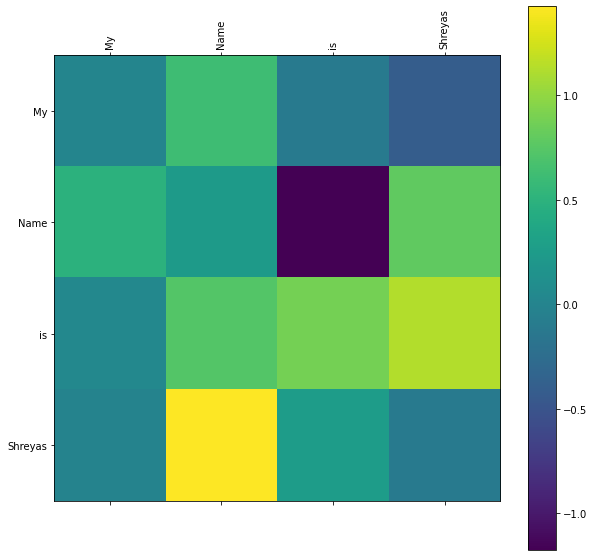

In [20]:
plot_attention(attention_weights, sentence)